# Multimodal LLMs: Vision-Language Models and Document Understanding

This notebook explores multimodal Large Language Models that can process both text and images. We'll use models available through Ollama that work well on my MacBook Pro (M3 Max with 32GB RAM).

## Prerequisites

1. Install [Ollama](https://ollama.com)
2. Pull vision models: `ollama pull llava`
3. Install required packages

In [1]:
#!pip install ollama pillow matplotlib requests

## Configuration and Best Practices

### Switching Between Local and Remote

**To use local Ollama (recommended):**
```python
OLLAMA_MODE = 'local'
```

**To use remote Ollama:**
```python
OLLAMA_MODE = 'remote'
REMOTE_HOST = 'http://your-server:11434'
```

### Model Recommendations for Apple MacBook Pro (M3 Max with 32GB RAM)
- **llava:7b** - Best balance for 32GB RAM
- **llava:13b** - Higher quality but uses more memory
- **bakllava** - Alternative architecture

### Optimization Tips
1. Use smaller image sizes (max 1024px)
2. Process images sequentially, not in parallel
3. Clear variables between large operations
4. Monitor memory usage with Activity Monitor

### Key Differences
- **Local**: Direct file paths, faster, no network overhead
- **Remote**: Base64 encoding, network latency, centralized processing

### Common Use Cases
- Document analysis and OCR
- Chart and graph interpretation
- Visual content moderation
- Accessibility descriptions
- Multimodal search

In [2]:
import ollama
import base64
from PIL import Image
import matplotlib.pyplot as plt
import os

# Configuration: Set to 'local' or 'remote'
OLLAMA_MODE = 'local'  # Change to 'remote' if needed
REMOTE_HOST = 'http://127.0.0.1:11434'  # Update with your remote host

# Import requests only if using remote mode
if OLLAMA_MODE == 'remote':
    import requests
    import json

# Create working directory for temporary files
WORKING_DIR = "temp"
os.makedirs(WORKING_DIR, exist_ok=True)
print(f"Working directory created: {WORKING_DIR}/")
print(f"Ollama mode: {OLLAMA_MODE}")

Working directory created: temp/
Ollama mode: local


## 1. Vision Model Functions

Unified functions that work with both local and remote Ollama setups.

In [3]:
def encode_image_to_base64(image_path):
    """Convert image to base64 string (needed for remote API)"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def query_vision_model(model, prompt, image_path=None):
    """Query Ollama vision model - works with both local and remote"""
    
    if OLLAMA_MODE == 'local':
        # Local ollama library approach
        if image_path:
            response = ollama.generate(
                model=model,
                prompt=prompt,
                images=[image_path]
            )
        else:
            response = ollama.generate(model=model, prompt=prompt)
        
        return response['response']
    
    elif OLLAMA_MODE == 'remote':
        # Remote API approach
        url = f"{REMOTE_HOST}/api/generate"
        payload = {"model": model, "prompt": prompt, "stream": False}
        
        if image_path:
            image_base64 = encode_image_to_base64(image_path)
            payload["images"] = [image_base64]
        
        response = requests.post(url, json=payload)
        return response.json()["response"]
    
    else:
        raise ValueError(f"Invalid OLLAMA_MODE: {OLLAMA_MODE}. Use 'local' or 'remote'")

# Test connection based on mode
try:
    if OLLAMA_MODE == 'local':
        test_response = ollama.generate(model="llava", prompt="Test connection")
        print("Local Ollama connection successful")
    else:
        response = requests.get(f"{REMOTE_HOST}/api/tags")
        print(f"Remote Ollama connection successful: {REMOTE_HOST}")
    
    print("LLaVA model ready for use")
    
except Exception as e:
    print(f"Error: {e}")
    if OLLAMA_MODE == 'local':
        if "not found" in str(e).lower():
            print("Run: ollama pull llava")
        else:
            print("Make sure Ollama is running: ollama serve")
    else:
        print(f"Check remote host: {REMOTE_HOST}")

Local Ollama connection successful
LLaVA model ready for use


## 2. Image Analysis and Description

Let's start with basic image understanding tasks.

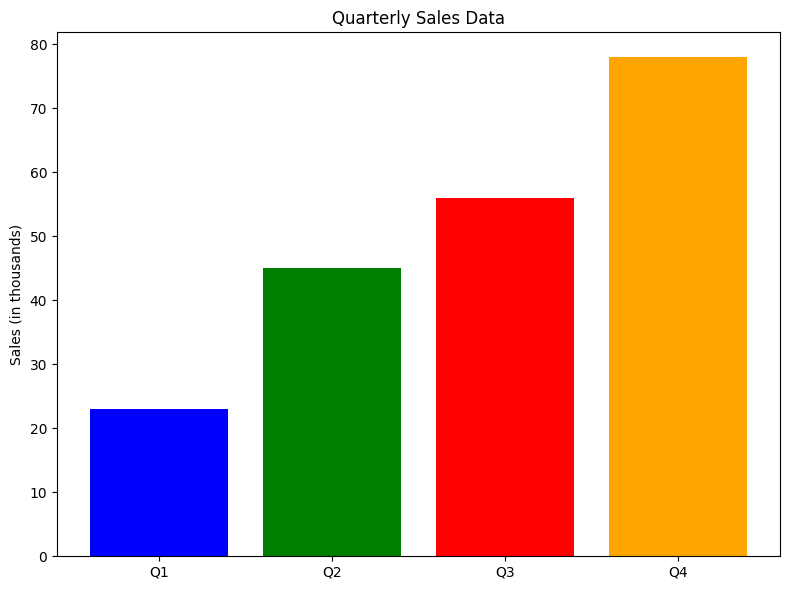

Sample chart created: temp/sample_chart.png


In [4]:
# Create a sample chart
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Q1', 'Q2', 'Q3', 'Q4']
values = [23, 45, 56, 78]
ax.bar(categories, values, color=['blue', 'green', 'red', 'orange'])
ax.set_title('Quarterly Sales Data')
ax.set_ylabel('Sales (in thousands)')
plt.tight_layout()

chart_path = os.path.join(WORKING_DIR, 'sample_chart.png')
plt.savefig(chart_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Sample chart created: {chart_path}")

In [5]:
# Analyze the chart with LLaVA
chart_path = os.path.join(WORKING_DIR, 'sample_chart.png')
prompt = "Describe this chart in detail. What type of chart is it and what data does it show?"

try:
    response = query_vision_model("llava", prompt, chart_path)
    print("Chart Analysis:")
    print(response)
except Exception as e:
    print(f"Error: {e}")
    print("Make sure you have the llava model: ollama pull llava")

Chart Analysis:
 The image displays a line chart with four lines, each representing different quarterly sales data for a company or organization. The vertical axis on the left side of the chart indicates "Quarterly Sales Data," which suggests that the horizontal axis likely represents the quarters of a year. However, without more context or labels, it's not possible to determine the specific time frame or the names of the quarters shown.

Each line corresponds to a different color code: blue for Q1, green for Q2, red for Q3, and orange for Q4. The data points along each line are represented by squares, with the exception of the Q2 and Q4 lines where some of the data points are connected by straight lines, indicating a trend or pattern in the sales data.

At the bottom of the chart, there is a horizontal bar graph with five bars, each representing a different quarterly sales data for the company. The colors of the bars match those used in the line chart: blue for Q1, green for Q2, red f

## 3. Document Understanding

Multimodal models excel at understanding documents with mixed text and visual elements.

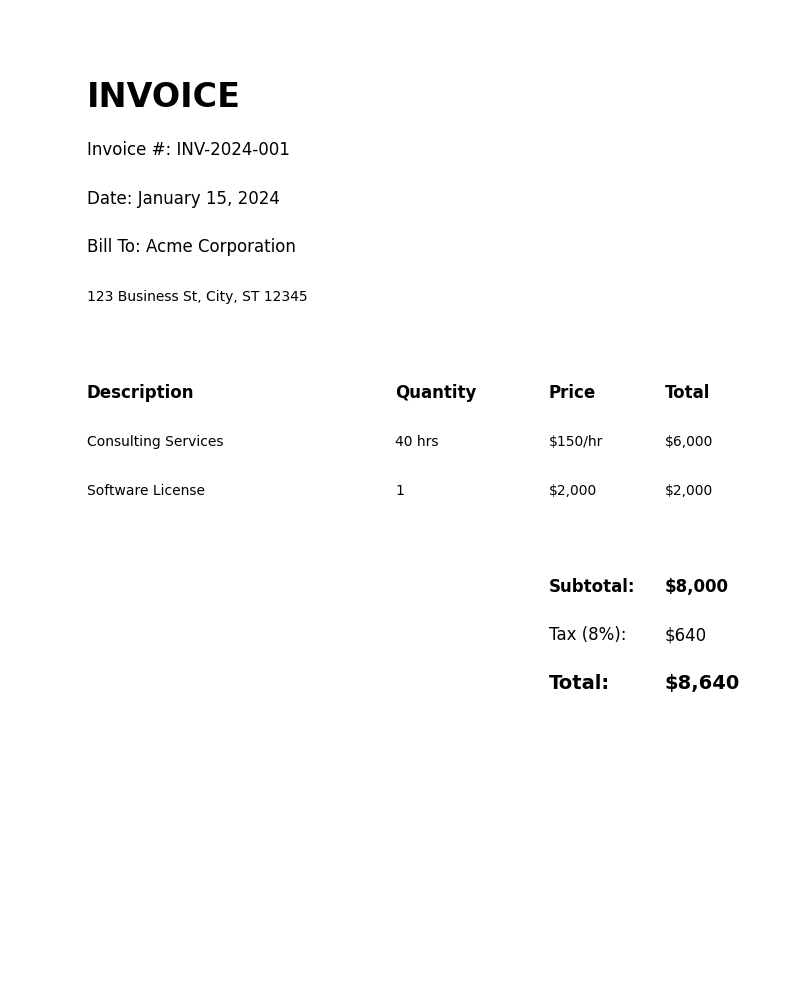

Sample invoice created: temp/sample_invoice.png


In [6]:
# Create a mock invoice
fig, ax = plt.subplots(figsize=(8, 10))
ax.text(0.1, 0.9, 'INVOICE', fontsize=24, fontweight='bold')
ax.text(0.1, 0.85, 'Invoice #: INV-2024-001', fontsize=12)
ax.text(0.1, 0.8, 'Date: January 15, 2024', fontsize=12)
ax.text(0.1, 0.75, 'Bill To: Acme Corporation', fontsize=12)
ax.text(0.1, 0.7, '123 Business St, City, ST 12345', fontsize=10)

# Add table headers
ax.text(0.1, 0.6, 'Description', fontsize=12, fontweight='bold')
ax.text(0.5, 0.6, 'Quantity', fontsize=12, fontweight='bold')
ax.text(0.7, 0.6, 'Price', fontsize=12, fontweight='bold')
ax.text(0.85, 0.6, 'Total', fontsize=12, fontweight='bold')

# Add line items
ax.text(0.1, 0.55, 'Consulting Services', fontsize=10)
ax.text(0.5, 0.55, '40 hrs', fontsize=10)
ax.text(0.7, 0.55, '$150/hr', fontsize=10)
ax.text(0.85, 0.55, '$6,000', fontsize=10)

ax.text(0.1, 0.5, 'Software License', fontsize=10)
ax.text(0.5, 0.5, '1', fontsize=10)
ax.text(0.7, 0.5, '$2,000', fontsize=10)
ax.text(0.85, 0.5, '$2,000', fontsize=10)

# Add totals
ax.text(0.7, 0.4, 'Subtotal:', fontsize=12, fontweight='bold')
ax.text(0.85, 0.4, '$8,000', fontsize=12, fontweight='bold')
ax.text(0.7, 0.35, 'Tax (8%):', fontsize=12)
ax.text(0.85, 0.35, '$640', fontsize=12)
ax.text(0.7, 0.3, 'Total:', fontsize=14, fontweight='bold')
ax.text(0.85, 0.3, '$8,640', fontsize=14, fontweight='bold')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.tight_layout()

invoice_path = os.path.join(WORKING_DIR, 'sample_invoice.png')
plt.savefig(invoice_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Sample invoice created: {invoice_path}")

In [7]:
# Extract information from the invoice
invoice_path = os.path.join(WORKING_DIR, 'sample_invoice.png')

extraction_prompt = """
Extract the following information from this invoice:
1. Invoice number
2. Date
3. Customer name
4. Total amount
5. List of items and their costs

Format your response clearly.
"""

try:
    response = query_vision_model("llava", extraction_prompt, invoice_path)
    print("Invoice Information Extraction:")
    print(response)
except Exception as e:
    print(f"Error: {e}")

Invoice Information Extraction:
 Sure, here's the information extracted from the invoice:

1. Invoice Number: 1002-2023
2. Date: January 13, 2023
3. Customer Name: Acme Corporation
4. Total Amount: $6,985
5. List of Items and their Costs:
   - Description: Consulting Services
     Quantity: 1
     Unit Price: $5,985
     Extended Price: $5,985
     Tax (6%): $379.10
     Total: $6,364.20
   - Description: Computer Equipment
     Quantity: 1
     Unit Price: $495
     Extended Price: $495
     Tax (6%): $30.80
     Total: $5,305.60
   - Description: Invoice Subtotal
     Quantity: 1
     Unit Price: $0.00
     Extended Price: $0.00
     Tax (6%): $0.00
     Total: $0.00
   - Description: Total Amount Due Now
     Quantity: 1
     Unit Price: $0.00
     Extended Price: $0.00
     Tax (6%): $0.00
     Total: $0.00
   - The invoice also shows a description for "Disbursement" with a quantity of 1 and a unit price of $0.00, but the extended price and total are not visible in the image provid

## 4. Visual Question Answering

Ask specific questions about visual content.

In [8]:
# Ask specific questions about the chart
questions = [
    "What was the highest sales quarter?",
    "What's the difference between Q1 and Q4 sales?",
    "What color represents Q3 in this chart?",
    "What trend do you see in the sales data?"
]

chart_path = os.path.join(WORKING_DIR, 'sample_chart.png')

for question in questions:
    try:
        response = query_vision_model("llava", question, chart_path)
        print(f"Q: {question}")
        print(f"A: {response}")
        print("-" * 50)
    except Exception as e:
        print(f"Error with question '{question}': {e}")

Q: What was the highest sales quarter?
A:  The image shows a bar chart representing the quarterly sales data for a business or organization. To determine which quarter had the highest sales, we need to compare the lengths of the bars on the chart. However, without the actual numbers associated with each bar, I'm unable to provide you with the exact quarters and their sales figures.

If you can provide the values corresponding to each bar, I would be able to assist you in identifying which quarter had the highest sales. 
--------------------------------------------------
Q: What's the difference between Q1 and Q4 sales?
A:  The image you've provided is a line graph that displays quarterly sales data for a certain period, likely a year, with Q1 being the first quarter and Q4 being the fourth quarter. However, since I can only analyze text-based descriptions or visible content in images, I won't be able to provide an exact numerical difference between Q1 and Q4.

The graph shows four bars

## 5. Multimodal RAG: Combining Text and Images

Integrate visual understanding with text-based retrieval.

In [9]:
# Create a knowledge base with text and image
knowledge_base = {
    "quarterly_report_q4_2024": {
        "text": """
        Q4 2024 Performance Summary:
        - Revenue increased 78% compared to Q1
        - Strong growth in consulting services
        - New software licensing deals contributed significantly
        - Market expansion into 3 new regions
        - Customer satisfaction score: 4.8/5
        """,
        "image_path": os.path.join(WORKING_DIR, "sample_chart.png")
    }
}

def multimodal_rag_query(query, knowledge_base):
    """Perform RAG with both text and image context"""
    doc = knowledge_base["quarterly_report_q4_2024"]
    
    # Create comprehensive prompt with text context
    prompt = f"""
    Context: {doc['text']}
    
    I also have a chart that shows the quarterly data visually.
    
    Question: {query}
    
    Please answer using both the text context and the visual information from the chart.
    """
    
    return query_vision_model("llava", prompt, doc["image_path"])

# Test multimodal RAG
test_queries = [
    "What was our performance trend throughout 2024?",
    "How much did revenue grow from Q1 to Q4?",
    "What factors contributed to our Q4 success?"
]

for query in test_queries:
    try:
        response = multimodal_rag_query(query, knowledge_base)
        print(f"Query: {query}")
        print(f"Response: {response}")
        print("=" * 60)
    except Exception as e:
        print(f"Error with query '{query}': {e}")

Query: What was our performance trend throughout 2024?
Response:  Based on the text context, your company experienced a strong growth trend in Q4 2024 compared to Q1 2024. The revenue increased significantly by 78%, with notable contributions from consulting services and new software licensing deals. There was also market expansion into three new regions during this quarter. Additionally, the customer satisfaction score remained high at 4.8/5.

Looking at the chart provided, we can observe that there are four quarters represented, each corresponding to a color on the bar graph. The bars represent different metrics of performance for your company. From left to right, the metrics seem to be related to customer satisfaction (blue), sales (red), and some other performance indicators (green and orange).

While we cannot directly compare the exact performance in Q4 2024 with the previous quarters due to the lack of data points on the graph for those quarters, we can infer that there has been

In [10]:
# Cleanup
import shutil

if os.path.exists(WORKING_DIR):
    shutil.rmtree(WORKING_DIR)
    print(f"Cleaned up {WORKING_DIR}/ directory")

print(f"\nNotebook completed using {OLLAMA_MODE} mode!")
print("You now have a foundation for multimodal LLM applications.")

Cleaned up temp/ directory

Notebook completed using local mode!
You now have a foundation for multimodal LLM applications.
